In [1]:
!nvidia-smi

Sun Jul  7 15:46:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro K620                    Off | 00000000:17:00.0 Off |                  N/A |
| 34%   41C    P8               1W /  30W |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

def list_all_gpus():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of GPUs available: {num_gpus}")
        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f"GPU {i}: {gpu_name}")
    else:
        print("No GPU available.")

# Example usage:
list_all_gpus()

import torch

def set_and_print_gpu(device_id):
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        if device_id >= num_gpus:
            print(f"Invalid device ID {device_id}. Only {num_gpus} GPU(s) available.")
        else:
            torch.cuda.set_device(device_id)
            gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
            print(f"Switched to GPU: {gpu_name}")
    else:
        print("No GPU available.")

# Example usage:
set_and_print_gpu(0)  # Change 0 to the desired GPU device ID



Number of GPUs available: 2
GPU 0: Tesla V100-PCIE-32GB
GPU 1: Quadro K620
Switched to GPU: Tesla V100-PCIE-32GB


In [2]:
import os
import json
import shutil



# import matplotlib.pyplot as plt
# import numpy as np
# import nibabel as nib

# from monai.losses import DiceLoss
# from monai.inferers import sliding_window_inference
# from monai import transforms
# from monai.transforms import (
#     AsDiscrete,
#     Activations,
# )

# from monai.config import print_config
# from monai.metrics import DiceMetric
# from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
# from monai import data
# from monai.data import decollate_batch
# from functools import partial

import torch

ImportError: cannot import name 'SwinTransformer' from 'monai.networks.blocks' (c:\Users\abul4\miniforge3\envs\swin\lib\site-packages\monai\networks\blocks\__init__.py)

Multiple versions of MONAI may have been installed?
Please see the installation guide: https://docs.monai.io/en/stable/installation.html


In [4]:

root_dir = "/home/abul/Downloads/"
print(root_dir)

/home/abul/Downloads/


In [5]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k, v in d.items():
#             print(k,"--",v)            
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
#                 print("**",d[k]) 
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]
#                 print("||",d[k]) 
                

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [6]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(
        datalist=datalist_json, basedir=data_dir, fold=fold
    )
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]

    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)
    print(len(train_files))
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    print(len(validation_files))
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    return train_loader, val_loader

In [7]:
data_dir = "/home/abul/Downloads/BraTS2020_Training_Data_Son"
json_list = "/home/abul/Downloads/brats20_folds_d.json"

roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 2
fold = 4
infer_overlap = 0.5
max_epochs = 200
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

172
40


/home/abul/miniforge3/envs/pytorch/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [8]:
print(train_loader, val_loader)

<monai.data.dataloader.DataLoader object at 0x7114a6dbe3e0> <monai.data.dataloader.DataLoader object at 0x7114a6dbe6e0>


In [9]:
x= next(iter(train_loader))
y= x.get(0)
# print(f'x shape={x.get(0)} dtype={x}')
print(f'y shape={type(y)} dtype={y}')

y shape=<class 'NoneType'> dtype=None


(240, 240, 155) (240, 240, 155)
image shape: (240, 240, 155), label shape: (240, 240, 155)


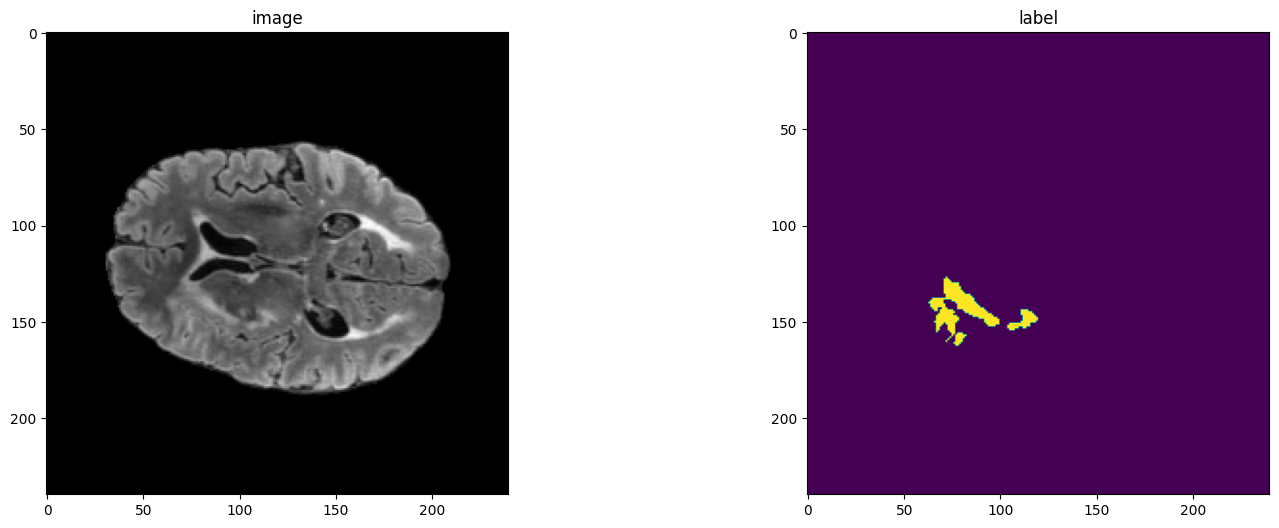

In [10]:
img_add = os.path.join(
    data_dir, "BraTS2020_00621/BraTS2020_00621_flair.nii"

)
label_add = os.path.join(

    data_dir, "BraTS2020_00621/BraTS2020_00621_seg.nii"
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(img.shape, label.shape)

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=12,
#     feature_size=16,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [12]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(
    include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True
)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [13]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()

    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
          
        )

    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
 
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(
                device
            )
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [
                post_pred(post_sigmoid(val_pred_tensor))
                for val_pred_tensor in val_outputs_list
            ]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            Dice_TC = run_acc.avg[0]
            Dice_WT = run_acc.avg[1]
            Dice_ET = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
              
            )
            

    return run_acc.avg

In [14]:
from itertools import islice as take
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):

    val_acc_max = 0.0
    Dices_TC = []
    Dices_WT = []
    Dices_ET = []
    Dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print( "Epoch:", epoch)
   
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss)
          
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
           
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            Dice_TC = val_acc[0]
            Dice_WT = val_acc[1]
            Dice_ET = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
                ", Dice_Avg:",
                val_avg_acc
            )
            Dices_TC.append(Dice_TC)
            Dices_WT.append(Dice_WT)
            Dices_ET.append(Dice_ET)
            Dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        Dices_TC,
        Dices_WT,
        Dices_ET,
        Dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [ ]:
start_epoch = 0

(
    val_acc_max,
    Dices_TC,
    Dices_WT,
    Dices_ET,
    Dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Epoch: 0
Epoch 0/200 0/86 loss: 0.9897
Epoch 0/200 1/86 loss: 0.9886
Epoch 0/200 2/86 loss: 0.9894
Epoch 0/200 3/86 loss: 0.9876
Epoch 0/200 4/86 loss: 0.9851
Epoch 0/200 5/86 loss: 0.9826
Epoch 0/200 6/86 loss: 0.9824
Epoch 0/200 7/86 loss: 0.9826
Epoch 0/200 8/86 loss: 0.9821
Epoch 0/200 9/86 loss: 0.9817
Epoch 0/200 10/86 loss: 0.9791
Epoch 0/200 11/86 loss: 0.9808
Epoch 0/200 12/86 loss: 0.9803
Epoch 0/200 13/86 loss: 0.9806
Epoch 0/200 14/86 loss: 0.9784
Epoch 0/200 15/86 loss: 0.9768
Epoch 0/200 16/86 loss: 0.9779
Epoch 0/200 17/86 loss: 0.9766
Epoch 0/200 18/86 loss: 0.9750
Epoch 0/200 19/86 loss: 0.9752
Epoch 0/200 20/86 loss: 0.9755
Epoch 0/200 21/86 loss: 0.9762
Epoch 0/200 22/86 loss: 0.9743
Epoch 0/200 23/86 loss: 0.9753
Epoch 0/200 24/86 loss: 0.9754
Epoch 0/200 25/86 loss: 0.9751
Epoch 0/200 26/86 loss: 0.9759
Epoch 0/200 27/86 loss: 0.9742
Epoch 0/200 28/86 loss: 0.9727
Epoch 0/200 29/86 loss: 0.9715
Epoch 0/200 30/86 loss: 0.9715
Epoch 0/200 31/86 loss: 0.9723
Epoch 0/2

In [ ]:

# !cp -r /tmp/tmpaw5e_03b/model.pt /kaggle/working
# 
# state_dict = model.state_dict()
# save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
# filename = os.path.join(dir_add, filename)
# torch.save(model.state_dict(), "/kaggle/working/model.pt")


# x, y = next(iter(train_loader))
# print(f'x shape={x.shape} dtype={x.dtype}')
# print(f'y shape={y.shape} dtype={y.dtype}')

# a,b = take(train_loader,None)
# print(a,b )/kaggle/working/tmp/tmpaw5e_03b/model.pt

In [ ]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_TC, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_WT, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_ET, color="purple")
plt.show()

In [ ]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2020_"
                + case_num
                + "/BraTS2020_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2020_"
                + case_num
                + "/BraTS2020_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2020_"
                + case_num
                + "/BraTS200_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2020_"
                + case_num
                + "/BraTS2020_"
                + case_num
                + "_flair.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2020_"
            + case_num
            + "/BraTS2020_"
            + case_num
            + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [ ]:
model.load_state_dict(torch.load(os.path.join("/kaggle/input/dataSwinUnet", "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

In [ ]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "BraTS2020_" + case_num + "/BraTS2020_" + case_num + "_flair.nii",
)
label_add = os.path.join(
    data_dir,
    "BraTS2020_" + case_num + "/BraTS2020_" + case_num + "_seg.nii",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)